In [3]:
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact

%matplotlib widget

In [4]:
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.size'] = 14

In [27]:
def gauss_2d(xy, *p):
    """2D gaussian."""
    x, y = xy
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = p

    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    z = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))

    return z.ravel()

interactive(children=(FloatSlider(value=200.0, description='sigma_x', max=400.0, step=4.0), FloatSlider(value=…

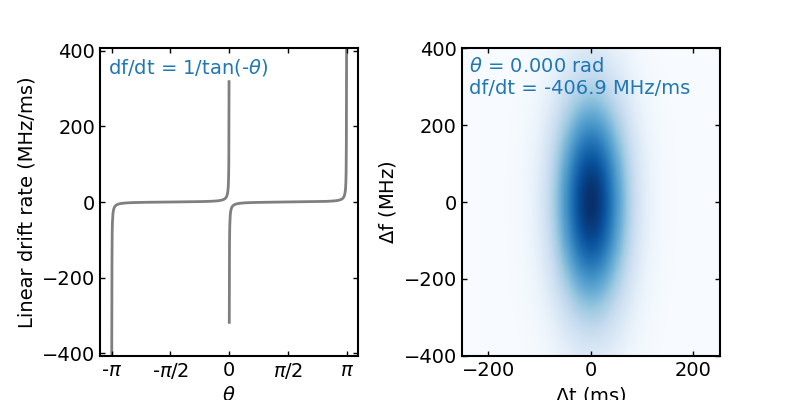

In [31]:
nchan = 1024
nsamp = 256

bw_mhz = 400
sampling_time_ms = 0.98304
channel_bandwidth_mhz = bw_mhz / 1024

sub_factor = 1
dim = (nchan * 2 + 1, nsamp * 2 + 1)

dts = np.arange(-dim[1] / 2 + 1, dim[1] / 2 + 1) * \
    sampling_time_ms
dfs = np.arange(-dim[0] / 2 + 1, dim[0] / 2 + 1) * \
    channel_bandwidth_mhz
    
x, y = [arr.T for arr in np.meshgrid(dfs, dts)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0.4})

xplot = np.linspace(-np.pi, np.pi, 1000)
drift_rates = 1. / np.tan(-xplot)
drift_rates[drift_rates > bw_mhz / sampling_time_ms] = \
    bw_mhz / sampling_time_ms
drift_rates[drift_rates < -bw_mhz / sampling_time_ms] = \
    -bw_mhz / sampling_time_ms

@widgets.interact(sigma_x=(0, bw_mhz, bw_mhz / 100), sigma_y=(0, bw_mhz, bw_mhz / 1000), theta=(-np.pi, np.pi, 0.01))
def update(sigma_x=200, sigma_y=50, theta=0):

    ax1.cla()
    ax2.cla()

    # relation between theta and df/dt under 1. / np.tan(-theta)
    ax1.plot(xplot[:len(xplot)//2], drift_rates[:len(xplot)//2], lw=2, color="tab:gray", zorder=1)
    ax1.plot(xplot[len(xplot)//2:], drift_rates[len(xplot)//2:], lw=2, color="tab:gray", zorder=1)
    
    ax1.set_xticks([-np.pi, -np.pi / 2., 0, np.pi / 2., np.pi,])
    ax1.set_xticklabels([r"-$\pi$", r"-$\pi$/2", "0", r"$\pi$/2", r"$\pi$"])
    
    ax1.set_ylim(-bw_mhz / sampling_time_ms, bw_mhz / sampling_time_ms)
    
    ax1.set_xlabel(r"$\theta$")
    ax1.set_ylabel("Linear drift rate (MHz/ms)")
    
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    
    xtext = 0.03 * (xlim[1] - xlim[0]) + xlim[0]
    ytext = 0.97 * (ylim[1] - ylim[0]) + ylim[0]
    
    ax1.text(xtext, ytext, r"df/dt = 1/tan(-$\theta$)",
             ha="left", va="top", color="tab:blue")
    
    ax2.set_xlabel("$\Delta$t (ms)")
    ax2.set_ylabel("$\Delta$f (MHz)")
    
    ax2.set_xlim(min(dts)-np.diff(dts)[0], max(dts)+np.diff(dts)[0])
    ax2.set_ylim(min(dfs)-np.diff(dfs)[0], max(dfs)+np.diff(dfs)[0])
    
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    
    xtext = 0.03 * (xlim[1] - xlim[0]) + xlim[0]
    ytext = 0.97 * (ylim[1] - ylim[0]) + ylim[0]
    
    ax1.plot(0, np.infty, marker="o", markersize=10, color="tab:blue")
    
    ax1.set_xticks([-np.pi, -np.pi / 2., 0, np.pi / 2., np.pi,])
    ax1.set_xticklabels([r"-$\pi$", r"-$\pi$/2", "0", r"$\pi$/2", r"$\pi$"])
    
    ax1.set_ylim(-bw_mhz / sampling_time_ms, bw_mhz / sampling_time_ms)
    
    ax1.set_xlabel(r"$\theta$")
    ax1.set_ylabel("Linear drift rate (MHz/ms)")

    # amp, x0, y0, sigma_x, sigma_y, theta, offset
    p0 = [10.0, 0.0, 0.0, sigma_x, sigma_y, theta, 0]
    
    model = gauss_2d((x, y), *p0).reshape(x.shape)
    
    im1 = ax2.imshow(model, aspect="auto", interpolation="nearest",
                     origin="lower", cmap="Blues",
                     extent=(min(dts)-np.diff(dts)[0],
                             max(dts)+np.diff(dts)[0],
                             min(dfs)-np.diff(dfs)[0],
                             max(dfs)+np.diff(dfs)[0]))
    
    drift_rate = 1. / np.tan(-p0[-2])
    ax1.scatter(theta, drift_rate, facecolor="tab:blue", zorder=2)
    
    if drift_rate > bw_mhz / sampling_time_ms:
        drift_rate = bw_mhz / sampling_time_ms
    elif drift_rate < -bw_mhz / sampling_time_ms:
        drift_rate = -bw_mhz / sampling_time_ms
    
    ax2.text(xtext, ytext, r"$\theta$ = "+ \
             "{:.3f} rad\ndf/dt = {:.1f} MHz/ms".format(
             theta, drift_rate), ha="left", va="top", color="tab:blue")